# Goals

* Assess UMI count distribution for CELLxGENE and scBaseCount
* Plot by metadata

In [1]:
import os
from typing import Optional, Union
from pathlib import Path
import numpy as np
import pandas as pd
import plotnine as pn
from pypika import Query, Table, functions as fn
import cellxgene_census
from collections import defaultdict
import tiledbsoma as soma
from SRAgent.db.connect import db_connect

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 4)
pn.theme_set(pn.theme_bw())

In [3]:
# get base of github repo
base_dir = !git rev-parse --show-toplevel
base_dir = Path(base_dir[0])
base_dir

PosixPath('/home/nickyoungblut/dev/python/scBaseCount_analysis')

In [4]:
# set tenant
os.environ["DYNACONF"] = "prod"

# Load CELLxGENE census data

In [5]:
with cellxgene_census.open_soma(census_version="2025-01-30") as census:
    print(census["census_data"]["homo_sapiens"].obs.schema)

soma_joinid: int64 not null
dataset_id: dictionary<values=string, indices=int16, ordered=0>
assay: dictionary<values=string, indices=int8, ordered=0>
assay_ontology_term_id: dictionary<values=string, indices=int8, ordered=0>
cell_type: dictionary<values=string, indices=int16, ordered=0>
cell_type_ontology_term_id: dictionary<values=string, indices=int16, ordered=0>
development_stage: dictionary<values=string, indices=int16, ordered=0>
development_stage_ontology_term_id: dictionary<values=string, indices=int16, ordered=0>
disease: dictionary<values=string, indices=int16, ordered=0>
disease_ontology_term_id: dictionary<values=string, indices=int16, ordered=0>
donor_id: dictionary<values=string, indices=int16, ordered=0>
is_primary_data: bool
observation_joinid: large_string
self_reported_ethnicity: dictionary<values=string, indices=int8, ordered=0>
self_reported_ethnicity_ontology_term_id: dictionary<values=string, indices=int8, ordered=0>
sex: dictionary<values=string, indices=int8, ord

In [6]:
def list_available_organisms(census_version: str = "stable") -> list:
    """List all available organisms in the census
    
    Args:
        census_version: Census version to use
        
    Returns:
        List of available organism names
    """
    with cellxgene_census.open_soma(census_version=census_version) as census:
        # The organisms are stored as keys in census["census_data"]
        census_data = census["census_data"]
        organisms = list(census_data.keys())
        
    return organisms

# List organisms
organisms = list_available_organisms(census_version="2025-01-30")
print(f"Available organisms: {organisms}")

Available organisms: ['homo_sapiens', 'mus_musculus']


In [7]:
# get obs metadata
df_cxg_obs = []
for organism in organisms:
    with cellxgene_census.open_soma(census_version="2025-01-30") as census:
        # info per cell
        df = census["census_data"][organism].obs.read(
            column_names=["dataset_id", "tissue_general", "raw_sum", "nnz"]
        ).concat().to_pandas().rename(
            columns={"raw_sum": "umi_count", "nnz": "gene_count", "tissue_general": "tissue"}
        )
        # add organism
        df["organism"] = organism
        # add dataset_id
        df_cxg_obs.append(df)

# aggregate by dataset_id, tissue, organism
df_cxg_obs = (
    pd.concat(df_cxg_obs)
    .dropna(subset=["umi_count", "gene_count"])
    .groupby(["dataset_id", "tissue", "organism"])
    .agg({
        "umi_count": "median",
        "gene_count": "median"
    }).reset_index()
)
df_cxg_obs["Atlas"] = "CELLxGENE"
df_cxg_obs

,dataset_id,tissue,organism,umi_count,gene_count,Atlas
0,0041b9c3-6a49-4bf7-8514-9bc7190067a7,mucosa,homo_sapiens,8191.0,2768.5,CELLxGENE
1,0041b9c3-6a49-4bf7-8514-9bc7190067a7,skin of body,homo_sapiens,9405.5,2279.0,CELLxGENE
...,...,...,...,...,...,...
1810,ff7d15fa-f4b6-4a0e-992e-fd0c9d088ded,brain,homo_sapiens,15295.0,5377.0,CELLxGENE
1811,ff995299-bf56-4d11-914d-b77949f02fb1,adipose tissue,homo_sapiens,7507.0,3153.0,CELLxGENE


# Load scBaseCount data

In [8]:
def get_screcounter_star_results(
    conn, 
    feature="GeneFull_Ex50pAS"
):
    """
    Get the screcounter_star_results table
    
    Args:
        conn: A database connection object (e.g., sqlite3, psycopg2, etc.)
        feature: String of the feature to filter on
    Returns:
        A pandas DataFrame of records
    """
    
    # Define tables
    meta_table = Table('srx_metadata')
    star_table = Table('screcounter_star_results')
    
    # Build the main query with join
    query = (
        Query.from_(star_table)
        .join(meta_table)
        .on(star_table.sample == meta_table.srx_accession)
        .select(
            star_table.sample.as_('srx_accession').as_('dataset_id'),
            star_table.median_umi_per_cell.as_('umi_count'),
            star_table.median_feature_per_cell.as_('gene_count'),
            meta_table.organism,
            meta_table.tissue
        )
        .where(
            fn.Lower(star_table.feature) == feature.lower()
        )
        .where(
            meta_table.lib_prep == "10x_Genomics",
        )
        .where(
            meta_table.organism.isin(["Homo sapiens", "Mus musculus"])
        )
    )
    
    # Execute query and return as DataFrame
    return pd.read_sql_query(str(query), conn)

with db_connect() as conn:
    df_scbc_obs = get_screcounter_star_results(conn, feature="GeneFull_Ex50pAS")
df_scbc_obs["Atlas"] = "scBaseCount"
df_scbc_obs

,dataset_id,umi_count,gene_count,organism,tissue,Atlas
0,SRX20732890,8551.0,3025.0,Homo sapiens,breast,scBaseCount
1,ERX10398458,4582.0,2276.0,Homo sapiens,Retina,scBaseCount
...,...,...,...,...,...,...
56703,NRX0000362,6458.0,2392.0,Homo sapiens,blood,scBaseCount
56704,NRX0000363,5220.0,2045.0,Homo sapiens,blood,scBaseCount


In [9]:
# load CellxGene tissue categories
df_tissue_cats = pd.read_csv(base_dir / "data" / "tissues" / "2025-06-30_tissue_categories.csv.gz")
df_tissue_cats

,tissue,category
0,2 layer spheroid,other
1,"3 layer spheroid channel 1,epithelial",other
...,...,...
15543,zebrafish larval intestines,intestine
15544,zebrafish marrow,bone marrow


In [10]:
# merge tissue categories
df_scbc_obs = df_scbc_obs.merge(
    df_tissue_cats, left_on="tissue", right_on="tissue", how="left"
).rename(columns={"category": "tissue_category"})
df_scbc_obs["tissue_category"] = df_scbc_obs["tissue_category"].apply(lambda x: "other" if pd.isna(x) else x)
df_scbc_obs

,dataset_id,umi_count,gene_count,organism,tissue,Atlas,tissue_category
0,SRX20732890,8551.0,3025.0,Homo sapiens,breast,scBaseCount,breast
1,ERX10398458,4582.0,2276.0,Homo sapiens,Retina,scBaseCount,eye
...,...,...,...,...,...,...,...
56703,NRX0000362,6458.0,2392.0,Homo sapiens,blood,scBaseCount,blood
56704,NRX0000363,5220.0,2045.0,Homo sapiens,blood,scBaseCount,blood


In [72]:
# format
df_scbc_obs = df_scbc_obs.drop(columns=["tissue"]).rename(columns={"tissue_category": "tissue"})
df_scbc_obs

,dataset_id,umi_count,gene_count,organism,Atlas,tissue
0,SRX22482811,985.0,677.0,Homo sapiens,scBaseCount,blood
1,SRX13824065,2371.0,1288.0,Mus musculus,scBaseCount,skin of body
...,...,...,...,...,...,...
56703,SRX10955666,1568.0,849.0,Mus musculus,scBaseCount,blood
56704,ERX11467033,4338.0,1949.0,Homo sapiens,scBaseCount,other


# Combine

In [73]:
print(df_cxg_obs["tissue"].nunique())
print(df_scbc_obs["tissue"].nunique())

70
68


In [74]:
df_obs = pd.concat([
    df_cxg_obs,
    df_scbc_obs
])
df_obs

,dataset_id,tissue,organism,umi_count,gene_count,Atlas
0,0041b9c3-6a49-4bf7-8514-9bc7190067a7,mucosa,homo_sapiens,8191.0,2768.5,CELLxGENE
1,0041b9c3-6a49-4bf7-8514-9bc7190067a7,skin of body,homo_sapiens,9405.5,2279.0,CELLxGENE
...,...,...,...,...,...,...
56703,SRX10955666,blood,Mus musculus,1568.0,849.0,scBaseCount
56704,ERX11467033,other,Homo sapiens,4338.0,1949.0,scBaseCount


# Plotting

## UMI counts

In [95]:
# get top 30 tissues by median umi count
## filter to top N tissues
df_obs_sum_topN = (
    df_obs[["tissue", "umi_count"]][df_obs["tissue"] != "other"]
    .groupby("tissue").sum()
    .sort_values("umi_count", ascending=False)
    .head(30)
    .reset_index()
)
df = df_obs[df_obs["tissue"].isin(df_obs_sum_topN["tissue"])]

## order by count
tissue_order = df_obs_sum_topN["tissue"].unique().tolist()
df["tissue"] = pd.Categorical(df["tissue"], categories=tissue_order)

## show result
df

/tmp/ipykernel_1249944/509125096.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,dataset_id,tissue,organism,umi_count,gene_count,Atlas
1,0041b9c3-6a49-4bf7-8514-9bc7190067a7,skin of body,homo_sapiens,9405.5,2279.0,CELLxGENE
2,00476f9f-ebc1-4b72-b541-32f912ce36ea,brain,homo_sapiens,18140.0,6000.0,CELLxGENE
...,...,...,...,...,...,...
56696,ERX4319232,heart,Homo sapiens,2602.0,1557.0,scBaseCount
56703,SRX10955666,blood,Mus musculus,1568.0,849.0,scBaseCount


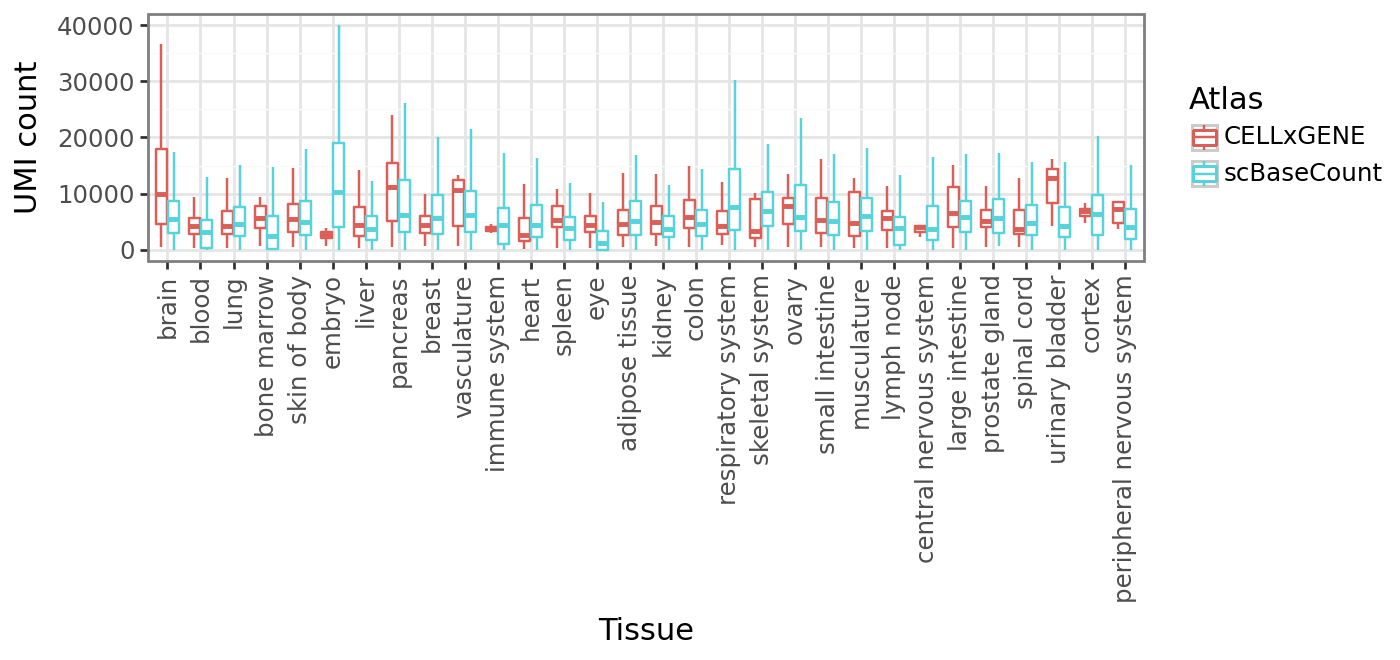

In [96]:
# plot
p = (
    pn.ggplot(
        df[df["umi_count"] <= 40000], 
        pn.aes(x="tissue", y="umi_count", color="Atlas")
    ) +
    pn.geom_boxplot(outlier_shape=None) +
    pn.labs(
        x = "Tissue",
        y = "UMI count",
        color = "Atlas",
    ) +
    pn.theme_bw() +
    pn.theme(
        figure_size=(7, 3.3),
        axis_text_x=pn.element_text(angle=90),
        legend_key_size=11, 
    )
)
p

In [97]:
# save as svg
outfile = base_dir / "figures" / "scBC-CxG_umi_counts.svg"
pn.ggsave(p, outfile)
print(f"File written to {outfile}")

/home/nickyoungblut/miniforge3/envs/SRAgent_nb/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 7 x 3.3 in image.
/home/nickyoungblut/miniforge3/envs/SRAgent_nb/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /home/nickyoungblut/dev/python/scBaseCount_analysis/figures/scBC-CxG_umi_counts.svg


File written to /home/nickyoungblut/dev/python/scBaseCount_analysis/figures/scBC-CxG_umi_counts.svg


# Gene counts

In [98]:
# get top 30 tissues by median gene count
## filter to top N tissues
df_obs_sum_topN = (
    df_obs[["tissue", "gene_count"]][df_obs["tissue"] != "other"]
    .groupby("tissue").sum()
    .sort_values("gene_count", ascending=False)
    .head(30)
    .reset_index()
)
df = df_obs[df_obs["tissue"].isin(df_obs_sum_topN["tissue"])]

## order by count
tissue_order = df_obs_sum_topN["tissue"].unique().tolist()
df["tissue"] = pd.Categorical(df["tissue"], categories=tissue_order)

# show result
df

/tmp/ipykernel_1249944/1168928777.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,dataset_id,tissue,organism,umi_count,gene_count,Atlas
1,0041b9c3-6a49-4bf7-8514-9bc7190067a7,skin of body,homo_sapiens,9405.5,2279.0,CELLxGENE
2,00476f9f-ebc1-4b72-b541-32f912ce36ea,brain,homo_sapiens,18140.0,6000.0,CELLxGENE
...,...,...,...,...,...,...
56696,ERX4319232,heart,Homo sapiens,2602.0,1557.0,scBaseCount
56703,SRX10955666,blood,Mus musculus,1568.0,849.0,scBaseCount


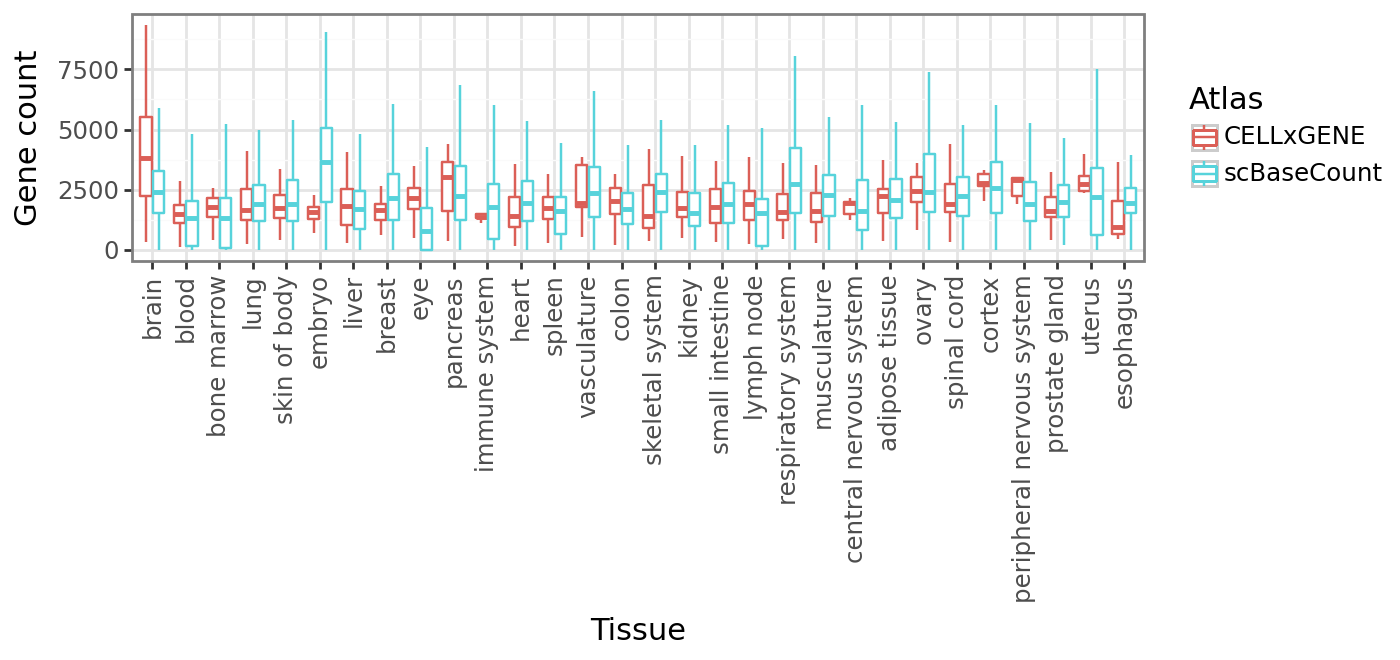

In [99]:
# plot
p = (
    pn.ggplot(
        df, pn.aes(x="tissue", y="gene_count", color="Atlas")
    ) +
    pn.geom_boxplot(outlier_shape=None) +
    pn.labs(
        x = "Tissue",
        y = "Gene count",
        color = "Atlas",
    ) +
    pn.theme_bw() +
    pn.theme(
        figure_size=(7, 3.3),
        axis_text_x=pn.element_text(angle=90),
        legend_key_size=11, 
    )
)
p

In [100]:
# save as svg
outfile = base_dir / "figures" / "scBC-CxG_gene_counts.svg"
pn.ggsave(p, outfile)
print(f"File written to {outfile}")

/home/nickyoungblut/miniforge3/envs/SRAgent_nb/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 7 x 3.3 in image.
/home/nickyoungblut/miniforge3/envs/SRAgent_nb/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /home/nickyoungblut/dev/python/scBaseCount_analysis/figures/scBC-CxG_gene_counts.svg


File written to /home/nickyoungblut/dev/python/scBaseCount_analysis/figures/scBC-CxG_gene_counts.svg


# session info

In [92]:
!conda list

# packages in environment at /home/nickyoungblut/miniforge3/envs/SRAgent_nb:
#
# Name                    Version                   Build  Channel
_libgcc_mutex             0.1                 conda_forge    conda-forge
_openmp_mutex             4.5                       2_gnu    conda-forge
_python_abi3_support      1.0                  hd8ed1ab_2    conda-forge
aiobotocore               2.23.0             pyhd8ed1ab_0    conda-forge
aiohappyeyeballs          2.6.1              pyhd8ed1ab_0    conda-forge
aiohttp                   3.11.14                  pypi_0    pypi
aioitertools              0.12.0             pyhd8ed1ab_1    conda-forge
aiosignal                 1.3.2              pyhd8ed1ab_0    conda-forge
anndata                   0.11.4             pyhd8ed1ab_0    conda-forge
annotated-types           0.7.0                    pypi_0    pypi
anthropic                 0.57.1                   pypi_0    pypi
anyio                     4.9.0                    pypi_0    pypi
appdir